帧数： 16000
声道数： 1
帧速率： 16000
实例的比特宽度，即每一帧的字节数 2


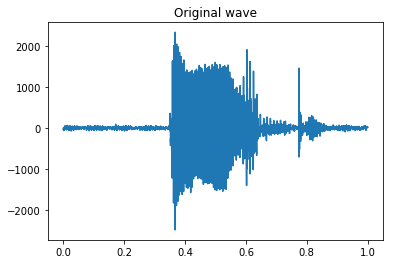

[ 0.51364299  0.51301812  0.51301812 ...,  0.51801708  0.51739221
  0.51864195]
Training epoch:  1 loss =  0.00783627
Training epoch:  2 loss =  0.0342863
Training epoch:  3 loss =  0.00410604
Training epoch:  4 loss =  0.00470531
Training epoch:  5 loss =  0.00313349
Training epoch:  6 loss =  0.00218185
Training epoch:  7 loss =  0.00130103
Training epoch:  8 loss =  0.000816585
Training epoch:  9 loss =  0.000785452
Training epoch:  10 loss =  0.00103775
Training epoch:  11 loss =  0.00131676
Training epoch:  12 loss =  0.00141696
Training epoch:  13 loss =  0.00127143
Training epoch:  14 loss =  0.000958191
Training epoch:  15 loss =  0.000633247
Training epoch:  16 loss =  0.000433508
Training epoch:  17 loss =  0.000403518
Training epoch:  18 loss =  0.000485536
Training epoch:  19 loss =  0.000572417
Training epoch:  20 loss =  0.000580655
Training epoch:  21 loss =  0.000494238
Training epoch:  22 loss =  0.000359478
Training epoch:  23 loss =  0.000244595
Training epoch:  24 l

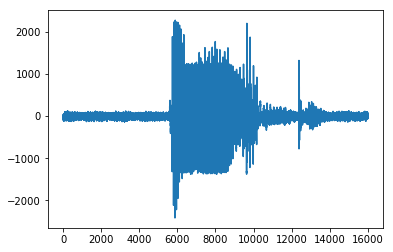

音频重建生成


In [14]:
import wave
import numpy as np
np.random.seed(1337)  # for reproducibility
import math
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
import tensorflow as tf

filename = './speech/bed/00f0204f_nohash_0.wav'
def read_wav_data(filename):
    '''
        读取一个wav文件，返回声音信号的时域谱矩阵和播放时间
    '''
    wav = wave.open(filename,"rb") # 打开一个wav格式的声音文件流
    num_frame = wav.getnframes() # 获取帧数
    print('帧数：',num_frame)
    num_channel=wav.getnchannels() # 获取声道数
    print('声道数：',num_channel)
    framerate=wav.getframerate() # 获取帧速率
    print('帧速率：',framerate)
    num_sample_width=wav.getsampwidth() # 获取实例的比特宽度，即每一帧的字节数
    print('实例的比特宽度，即每一帧的字节数',num_sample_width)
    str_data = wav.readframes(num_frame) # 读取全部的帧
    wav.close() # 关闭流
    wave_data = np.fromstring(str_data, dtype = np.short) # 将声音文件数据转换为数组矩阵形式
    wave_data.shape = -1, num_channel # 按照声道数将数组整形，单声道时候是一列数组，双声道时候是两列的矩阵
    wave_data = wave_data.T # 将矩阵转置
    return wave_data, framerate, num_frame, num_channel, num_sample_width, str_data
def wav_show(wave_data, fs): # 显示出来声音波形
    time = np.arange(0, len(wave_data)) * (1.0/fs)  # 计算声音的播放时间，单位为秒
    # 画声音波形
    plt.plot(time, wave_data) 
    plt.title('Original wave')
    plt.show()  
def minmax_norm(x):
    x = (x-min(x))/(max(x)-min(x))
    print(x)
    return x
#生成重建的wav
def Generate_Wav(filename, wave_data, framerate, num_frame, num_channel, num_sample_width):
    
    wave_data = wave_data.astype(np.short)
    #open a wav document
    f = wave.open(filename,"wb")
    #set wav params
    f.setnchannels(num_channel)
    f.setsampwidth(num_sample_width)
    f.setframerate(framerate)
    f.setnframes(num_frame)
    #turn the data to string
    f.writeframes(wave_data.tostring())
    f.close()

    
wave_data, fs, num_frame, num_channel, num_sample_width, str_data = read_wav_data(filename)  
wav_show(wave_data[0],fs)
wave_data=wave_data[0]
    
# data pre-processing
# x_train = wave_data.astype('float32') + max(wave_data)   # minmax_normalized
xmax = max(wave_data)
xmin = min(wave_data)
x_train = minmax_norm(wave_data)
#print((x_train))

#x_train = 10*[x_train]
# Hyper Parameters
train_epochs = 30 # 训练轮数
BATCH_SIZE = 64
LR = 0.05         # learning rate
# tf placeholder
tf_x = tf.placeholder(tf.float32, [None, 16000])    # value in the range of (0, 1)

# encoder
encode1 = tf.layers.dense(tf_x, 1600,tf.nn.sigmoid)
encode2 = tf.layers.dense(encode1,800,tf.nn.sigmoid)
encode3 = tf.layers.dense(encode2,400,tf.nn.sigmoid)
encoded = tf.layers.dense(encode3,160,tf.nn.sigmoid)



# decoder
decode1 = tf.layers.dense(encoded, 400, tf.nn.sigmoid)
decode2 = tf.layers.dense(decode1, 800, tf.nn.sigmoid)
decoded = tf.layers.dense(decode2, 16000, tf.nn.sigmoid)
loss = tf.reduce_mean(tf.square(tf_x - decoded))
train = tf.train.AdamOptimizer(LR).minimize(loss)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(train_epochs):
    
    # AWGN信道
    noise = tf.random_normal([160],mean=0,stddev=100,dtype=tf.float32,seed=None,name=None)
    encoded = tf.add(encoded,noise,name = 'encoded')
    
    _, loss_, ecoded_, decoded_=(sess.run([train, loss, encoded, decoded], {tf_x:[x_train]}))
    print('Training epoch: ',epoch+1, 'loss = ', loss_)
    
print('**************************最终结果****************************************')
decoded_=decoded_[0]
decoded_ = decoded_*(xmax-xmin)+xmin # denormalized
mse = np.mean(pow(abs(wave_data-decoded_),2))
print('mse: ',mse)
plt.plot(decoded_)
plt.show()
plt.title('Reconstructed wave')
filename = './reconstruct_bed.wav'
Generate_Wav(filename, decoded_, fs, num_frame, num_channel, num_sample_width )
print('音频重建生成')